In [ ]:
import pandas as pd
import numpy as np
import sys

from keras import backend as K
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers.convolutional import Conv1D
from keras.layers import Flatten, Reshape
from keras.layers.merge import concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import load_model

In [ ]:
MESG_SIZE = 16
KEY_SIZE = 16
LEARNING_RATE = 0.001

In [ ]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

In [ ]:
K.clear_session()

##### Alice network #####
#
InputAlice0 = Input(shape=(MESG_SIZE,)) #message
InputAlice1 = Input(shape=(KEY_SIZE,)) #key
InputAlice = concatenate([InputAlice0, InputAlice1], axis=1)

DenseAlice1 = Dense(units=(MESG_SIZE + KEY_SIZE))(InputAlice)
DenseAlice1a = Activation('tanh')(DenseAlice1)
Alicereshape = Reshape((MESG_SIZE + KEY_SIZE, 1,))(DenseAlice1a)

ConvAlice1 = Conv1D(filters=2, kernel_size=4, strides=1, padding='same',  activation = 'tanh')(Alicereshape)
ConvAlice2 = Conv1D(filters=4, kernel_size=2, strides=2, padding='same',  activation = 'tanh')(ConvAlice1)
ConvAlice3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same',  activation = 'tanh')(ConvAlice2)
ConvAlice4 = Conv1D(filters=1, kernel_size=1, strides=1, padding='same',  activation = 'sigmoid')(ConvAlice3)

OutputAlice = Flatten()(ConvAlice4)

Alice = Model([InputAlice0, InputAlice1], OutputAlice, name='alice')
#alice.summary()


##### Bob network #####
#
InputBob0 = Input(shape=(MESG_SIZE,)) #ciphertext
InputBob1 = Input(shape=(KEY_SIZE,)) #key
InputBob = concatenate([InputBob0, InputBob1], axis=1)

DenseBob1 = Dense(units=(MESG_SIZE + KEY_SIZE))(InputBob)
DenseBob1a = Activation('tanh')(DenseBob1)

bobReshape = Reshape((MESG_SIZE + KEY_SIZE, 1,))(DenseBob1a)

convBob1 = Conv1D(filters=2, kernel_size=4, strides=1, padding='same', activation ='tanh')(bobReshape)
convBob2 = Conv1D(filters=4, kernel_size=2, strides=2, padding='same', activation ='tanh')(convBob1)
convBob3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', activation ='tanh')(convBob2)
convBob4 = Conv1D(filters=1, kernel_size=1, strides=1, padding='same', activation ='sigmoid')(convBob3)
boutput = Flatten()(convBob4)

Bob = Model([InputBob0, InputBob1], boutput, name='bob')
#bob.summary()


# Eve network
#
inputEve = Input(shape=(MESG_SIZE,)) #ciphertext only

denseEve1 = Dense(units=(MESG_SIZE + KEY_SIZE))(inputEve)
denseEve1a = Activation('tanh')(denseEve1)

denseEve2 = Dense(units=(MESG_SIZE + KEY_SIZE))(denseEve1a)
denseEve2a = Activation('tanh')(denseEve2)

eveReshape = Reshape((MESG_SIZE + KEY_SIZE, 1,))(denseEve2a)

convoEve1 = Conv1D(filters=2, kernel_size=4, strides=1, padding='same', activation ='tanh')(eveReshape)
convoEve2 = Conv1D(filters=4, kernel_size=2, strides=2, padding='same', activation ='tanh')(convoEve1)
convoEve3 = Conv1D(filters=4, kernel_size=1, strides=1, padding='same', activation ='tanh')(convoEve2)
convoEve4 = Conv1D(filters=1, kernel_size=1, strides=1, padding='same', activation ='sigmoid')(convoEve3)

eveOutput = Flatten()(convoEve4)# Eve's attempt at code guessing

Eve = Model(inputEve, eveOutput, name='eve')

In [ ]:
Alice.compile(loss='mse', optimizer='sgd')
Bob.compile(loss='mse', optimizer='sgd')
Eve.compile(loss='mse', optimizer='sgd')

In [ ]:
lossesAliceBob = list()
lossesBob = list()
lossesEve = list()

In [ ]:
aliceOutput = Alice([InputAlice0, InputAlice1])
bobOut = Bob( [aliceOutput, InputBob1] )# bob sees ciphertext AND key
eveOut = Eve( aliceOutput )# eve doesn't see the key, only the cipher
t_loss = K.sum(K.abs(InputAlice0 - eveOut), axis=-1)
eveloss = K.mean(t_loss)

b_loss = K.sum(K.abs(InputAlice0 - bobOut), axis=-1)
bobloss = K.mean(b_loss)
abeloss = bobloss 
abeloss += K.square(MESG_SIZE/2 - eveloss)/( (MESG_SIZE//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=LEARNING_RATE)
eveoptim = RMSprop(lr=LEARNING_RATE) 


aliceBobModel = Model([InputAlice0, InputAlice1, InputBob1], bobOut, name='abemodel')
aliceBobModel.add_loss(abeloss)
aliceBobModel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
Alice.trainable = False
eveModel = Model([InputAlice0, InputAlice1], eveOut, name='eveModel')
eveModel.add_loss(eveloss)
eveModel.compile(optimizer=eveoptim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
epochs = 15
batch_size = 128
batches = (2**(MESG_SIZE)) // batch_size

for epoch in range(epochs):
    lossesAliceBob_l = list()
    lossesBob_l = list()
    lossesEve_l = list()

    for ii in range(batches):
        
        # Train the A-B+E network
        #
        Alice.trainable = True
        
        MSG = np.random.randint(0, 2, MESG_SIZE * batch_size).reshape(batch_size, MESG_SIZE)
        KEY = np.random.randint(0, 2, KEY_SIZE * batch_size).reshape(batch_size, KEY_SIZE)
        loss = aliceBobModel.train_on_batch([MSG, KEY, KEY], None)
        
        lossesAliceBob_l.append(loss)
        lossesAliceBob.append(loss)
        abeavg = np.mean(lossesAliceBob_l)
        if ii==batches-1:
          lossesAliceBob.append(loss)
          
            
         ### BOB NETWORK ####
        m_enc = Alice.predict([MSG, KEY])
        m_dec = Bob.predict([m_enc, KEY])
        temp_loss=np.sum( np.abs(MSG - m_dec), axis=-1)
        loss = np.mean(temp_loss)
        lossesBob_l.append(loss)
        lossesBob.append(loss)
        bobavg = np.mean(lossesBob_l)
        
        ### EVE NETWORK ####
        Alice.trainable = False
        for cycle in range(2):
            MSG = np.random.randint(0, 2, MESG_SIZE * batch_size).reshape(batch_size, MESG_SIZE)
            KEY = np.random.randint(0, 2, KEY_SIZE * batch_size).reshape(batch_size, KEY_SIZE)
            loss = eveModel.train_on_batch([MSG, KEY], None)
        
        lossesEve_l.append(loss)
        lossesEve.append(loss)
        eveavg = np.mean(lossesEve_l)


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
height = 8
width = 4

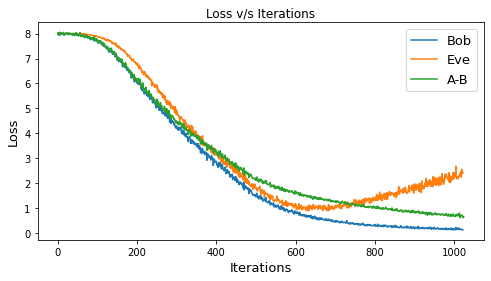

In [ ]:
steps = -1

plt.figure(figsize=(height,width ))
plt.plot(lossesBob[:steps], label='Bob')
plt.plot(lossesEve[:steps], label='Eve')
plt.plot(lossesAliceBob[:steps], label='A-B')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)
plt.title('Loss v/s Iterations')
plt.show()